# Panoptic Segmentation: Particle & Interaction Clustering

This notebook demonstrates panoptic segmentation using Panda's fine-tuned models. Panoptic segmentation combines semantic segmentation with instance segmentation to identify individual objects.

We provide two levels of clustering:
- **Particle clustering**: Groups points belonging to the same particle (e.g., a single electron track)
- **Interaction clustering**: Groups points belonging to the same interaction (i.e., points that are causally linked)

**Particle ID Classes:**
| ID | Particle |
|----|----------|
| 0 | Photon |
| 1 | Electron |
| 2 | Muon |
| 3 | Pion |
| 4 | Proton |
| 5 | LED (None) |

## 1. Load Data

In [1]:
import panda
import torch
import numpy as np

# auto-download from HuggingFace (or use local data_root if available)
dataset = panda.PILArNetH5Dataset(split="test", energy_threshold=0.13)

# read in random event
data = dataset[np.random.randint(0, len(dataset))]
for k in data.keys():
    data[k] = data[k].cuda(non_blocking=True)

In [2]:
print("\n".join(data.keys()))

coord
grid_coord
instance_particle
instance_interaction
energy
segment_particle
segment_motif
segment_interaction
offset
feat


## 2. Particle Clustering

The `particle` model segments individual particles and classifies their type (photon, electron, muon, pion, proton).

The model outputs masks which are postprocessed into instance labels with confidence scores.

In [3]:
# load in model
model = panda.load("particle").cuda()

# run inference
with torch.inference_mode():
    # generate masks
    output = model(data)
    # postprocess masks into particles
    result = model.postprocess(
        output, stuff_threshold=0.5, mask_threshold=0.5, conf_threshold=0.5
    )

In [4]:
result

{'instance_labels': tensor([ 6,  6,  6,  ..., -1, -1, -1], device='cuda:0'),
 'class_labels': tensor([2, 2, 2,  ..., 5, 5, 5], device='cuda:0'),
 'confidences': tensor([0.9972, 0.9972, 0.9972,  ..., 1.0000, 1.0000, 0.9999], device='cuda:0')}

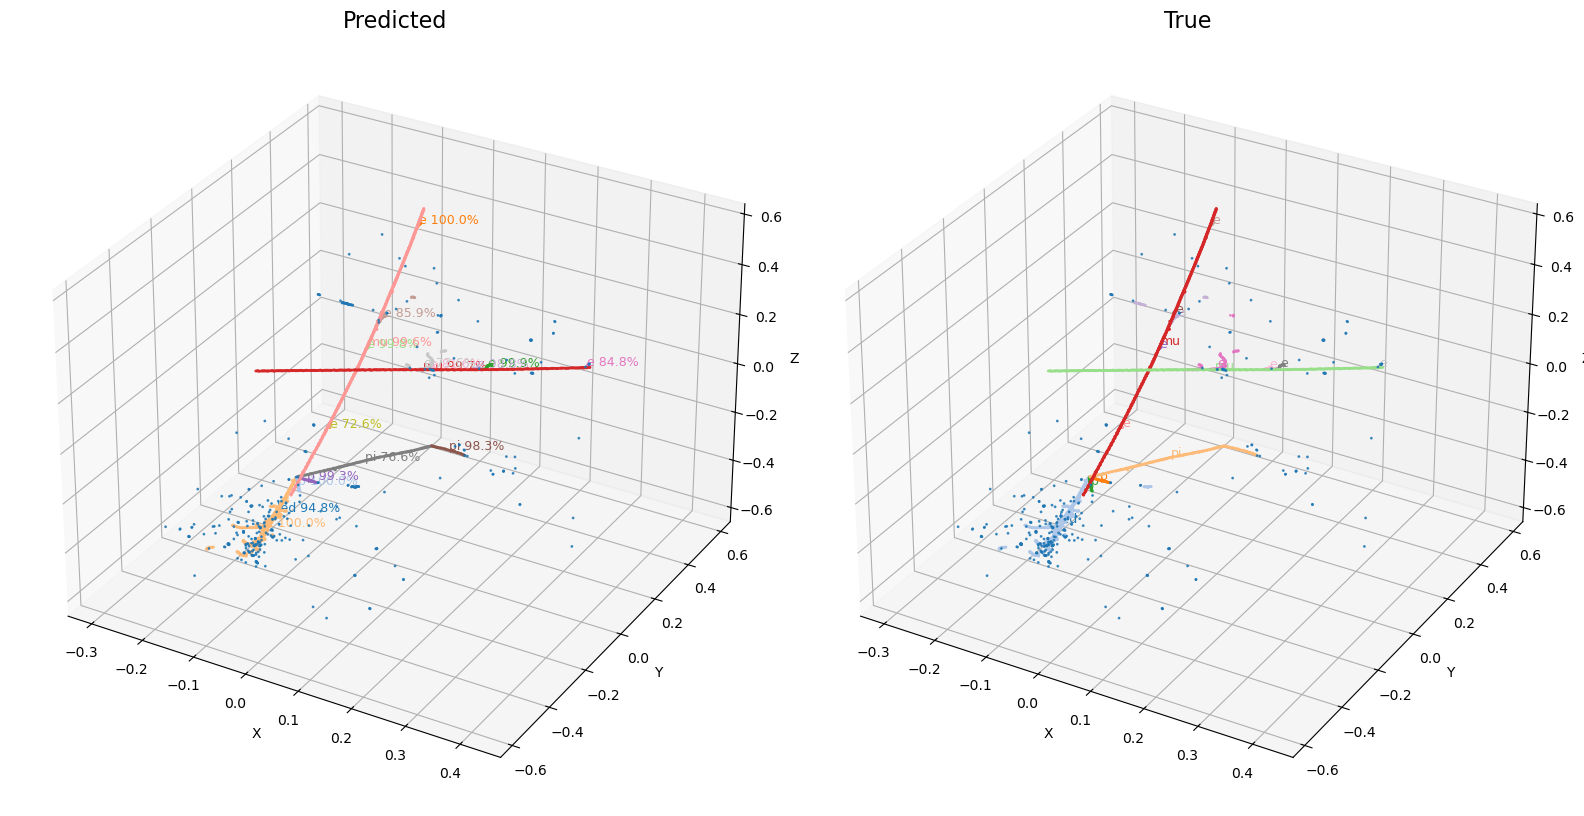

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

CLS_TO_NAME = {0: 'ph', 1:'e', 2:'mu', 3:'pi', 4:'p', 5:'led'}
coords = data['coord'].cpu().numpy()

# --- Predicted ---
instance_labels_pred = result['instance_labels'].cpu().numpy()
class_labels_pred = result['class_labels'].cpu().numpy()
confidences_pred = result['confidences'].cpu().numpy()
unique_instances_pred = np.unique(instance_labels_pred)

cmap = plt.get_cmap('tab20')
instance_to_color_pred = {inst: cmap(i % 20) for i, inst in enumerate(unique_instances_pred)}

# --- Ground Truth ---
instance_labels_true = data['instance_particle'].squeeze(-1).cpu().numpy()
class_labels_true = data['segment_particle'].squeeze(-1).cpu().numpy()
unique_instances_true = np.unique(instance_labels_true)
instance_to_color_true = {inst: cmap(i % 20) for i, inst in enumerate(unique_instances_true)}


fig = plt.figure(figsize=(16, 8))

# Plot 1: Predicted
ax1 = fig.add_subplot(121, projection='3d')
for i, inst in enumerate(unique_instances_pred):
    mask = instance_labels_pred == inst
    ax1.scatter(
        coords[mask, 0],
        coords[mask, 1],
        coords[mask, 2],
        color=instance_to_color_pred[inst],
        label=f'Instance {inst}',
        s=1,
        alpha=0.8
    )
    median_xyz = np.median(coords[mask], axis=0)
    inst_class = class_labels_pred[mask][0]
    inst_name = CLS_TO_NAME[inst_class]
    inst_conf = confidences_pred[mask][0] * 100
    ax1.text(
        median_xyz[0], median_xyz[1], median_xyz[2],
        f"{inst_name} {inst_conf:.1f}%",
        color=instance_to_color_pred[inst], fontsize=9
    )
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.set_title("Predicted", fontsize=16)

# Plot 2: Ground Truth
ax2 = fig.add_subplot(122, projection='3d')
for i, inst in enumerate(unique_instances_true):
    mask = instance_labels_true == inst
    ax2.scatter(
        coords[mask, 0],
        coords[mask, 1],
        coords[mask, 2],
        color=instance_to_color_true[inst],
        label=f'True Inst {inst}',
        s=1,
        alpha=0.8
    )
    median_xyz = np.median(coords[mask], axis=0)
    inst_class = class_labels_true[mask][0]
    inst_name = CLS_TO_NAME[inst_class]
    ax2.text(
        median_xyz[0], median_xyz[1], median_xyz[2],
        f"{inst_name}",
        color=instance_to_color_true[inst], fontsize=9
    )
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")
ax2.set_title("True", fontsize=16)

plt.tight_layout()
plt.show()


## 3. Interaction Clustering

The `interaction` model groups particles that originated from the same neutrino interaction. This is useful for event reconstruction.

Each interaction instance contains multiple particles from a single physics event.

In [6]:
# load in model
model = panda.load("interaction").cuda()

# run inference
with torch.inference_mode():
    # generate masks
    output = model(data)
    # postprocess masks into particles
    result = model.postprocess(
        output, stuff_threshold=0.5, mask_threshold=0.5, conf_threshold=0.5
    )

In [7]:
result

{'instance_labels': tensor([ 1,  1,  1,  ..., -1, -1, -1], device='cuda:0'),
 'class_labels': tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0'),
 'confidences': tensor([0.9945, 0.9945, 0.9945,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0')}

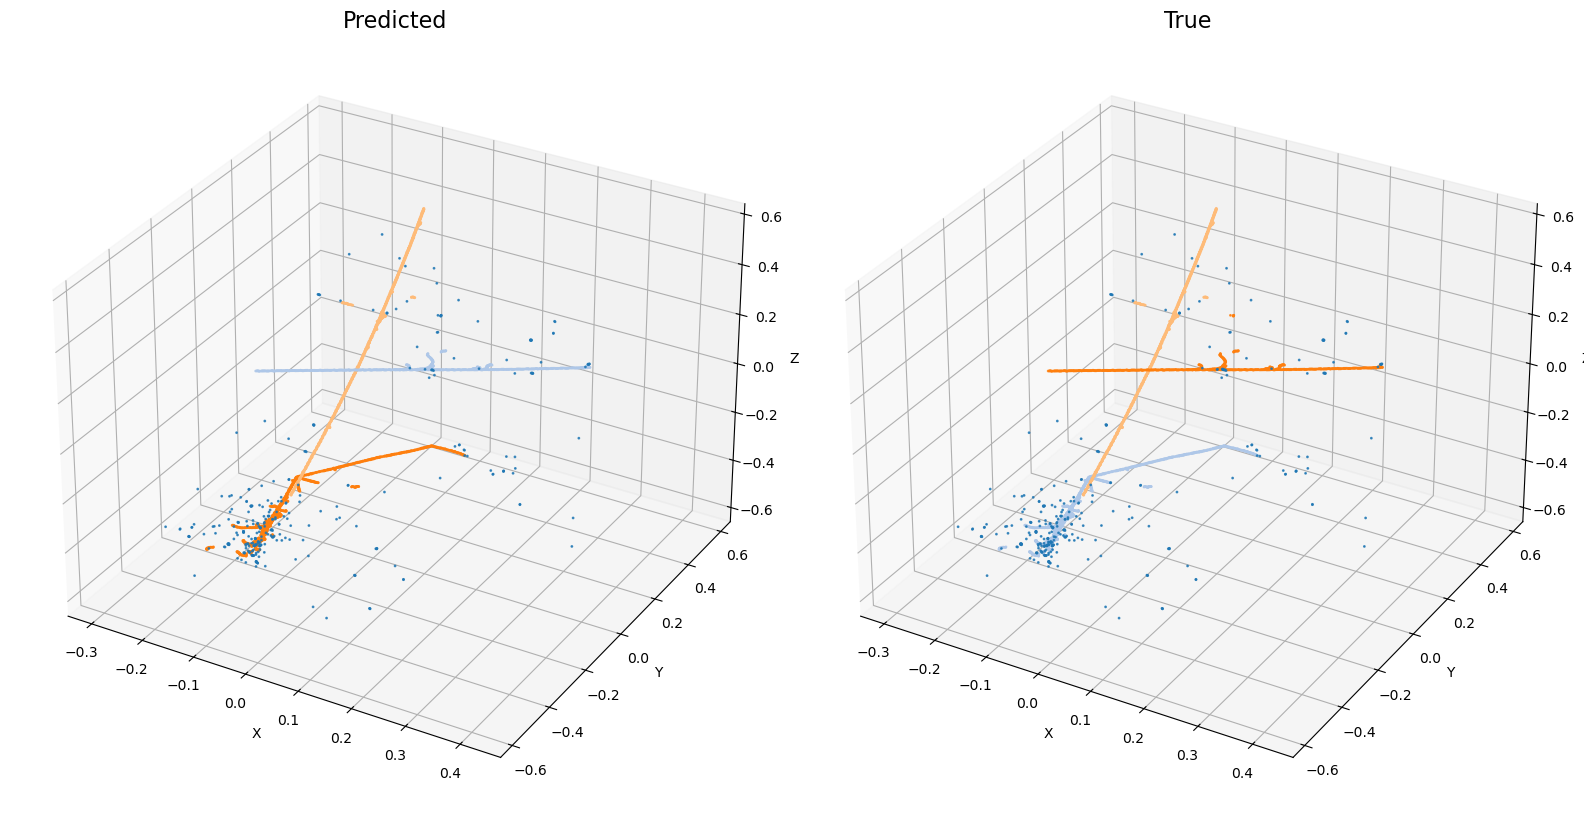

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

coords = data["coord"].cpu().numpy()

# --- Predicted ---
instance_labels_pred = result["instance_labels"].cpu().numpy()
class_labels_pred = result["class_labels"].cpu().numpy()
confidences_pred = result["confidences"].cpu().numpy()
unique_instances_pred = np.unique(instance_labels_pred)

cmap = plt.get_cmap("tab20")
instance_to_color_pred = {
    inst: cmap(i % 20) for i, inst in enumerate(unique_instances_pred)
}

# --- Ground Truth ---
instance_labels_true = data["instance_interaction"].squeeze(-1).cpu().numpy()
class_labels_true = data["segment_interaction"].squeeze(-1).cpu().numpy()
unique_instances_true = np.unique(instance_labels_true)
instance_to_color_true = {
    inst: cmap(i % 20) for i, inst in enumerate(unique_instances_true)
}


fig = plt.figure(figsize=(16, 8))

# Plot 1: Predicted
ax1 = fig.add_subplot(121, projection="3d")
for i, inst in enumerate(unique_instances_pred):
    mask = instance_labels_pred == inst
    ax1.scatter(
        coords[mask, 0],
        coords[mask, 1],
        coords[mask, 2],
        color=instance_to_color_pred[inst],
        label=f"Instance {inst}",
        s=1,
        alpha=0.8,
    )
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")
ax1.set_title("Predicted", fontsize=16)

# Plot 2: Ground Truth
ax2 = fig.add_subplot(122, projection="3d")
for i, inst in enumerate(unique_instances_true):
    mask = instance_labels_true == inst
    ax2.scatter(
        coords[mask, 0],
        coords[mask, 1],
        coords[mask, 2],
        color=instance_to_color_true[inst],
        label=f"True Inst {inst}",
        s=1,
        alpha=0.8,
    )
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")
ax2.set_title("True", fontsize=16)

plt.tight_layout()
plt.show()
